In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tike

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', family='Times New Roman')
plt.rcParams["mathtext.fontset"] = 'stix'

#width = 3.37 or 6.69 eps are preferred

In [3]:
#########|#########|#########|#########|#########|#########|#########|#########|

import matplotlib.patches as mpatches
import numpy as np

def draw_circles(axis, h, v, width=1, **kwargs):
    """Draw circles on the axis at coordinates (h, v)."""
    # Flatten the coordinates for linear indexing
    h = np.asarray(h).flatten()
    v = np.asarray(v).flatten()
    radius = width * 0.5
    for i in range(len(h)):
        axis.add_patch(mpatches.Circle((h[i], v[i]), radius=radius, **kwargs))   

In [4]:
#########|#########|#########|#########|#########|#########|#########|#########|

import matplotlib.patches as mpatches
import xdesign

def draw_mura(axis, h, v, mura, width=1, **kwargs):
    """Draw the MURA on the axis at coordinates (h, v).
    
    h and v are center of the MURA.
    """
    mura = np.asarray(mura)
    L = mura.shape[0]
    width = width / L  # The width of each MURA pixel
    # Generate coordinates for each pixel of the MURA
    x, y = np.meshgrid(
        np.linspace(0, 1, L, endpoint=False) - 0.5,
        np.linspace(0, 1, L, endpoint=False) - 0.5,
        indexing='ij',
    )
    # Flatten all the coordinates for linear indexing
    x = x.flatten()
    y = y.flatten()
    h = np.asarray(h).flatten()
    v = np.asarray(v).flatten()
    mura = mura.flatten()
    for i in range(len(h)):
        for j in range(len(x)):
             if mura[j]:
                axis.add_patch(mpatches.Rectangle(
                    (h[i] + x[j], v[i] + y[j]),
                    width=width, height=width,
                    **kwargs
                ))

In [5]:
#########|#########|#########|#########|#########|#########|#########|#########|

import tike
import numpy as np


def filter_neighbors(h, v, circles, touching=True, nontouching=False):
    is_center = (h == 0) & (v == 0)
    if circles:
        is_touching = np.sqrt(h*h + v*v) < 1 - 1e-12
    else:
        is_touching = np.logical_and(np.abs(h) < 1 - 1e-12, np.abs(v) < 1 - 1e-12)
    
    keep = False 
    if touching:
        keep = keep | (~is_center & is_touching)
    if nontouching:
        keep = keep | (~is_center & ~is_touching)
    return h[keep], v[keep]


def rectangular_neighbors(shift, circles=True, touching=True, nontouching=False):
    """Return coordinates of all regtangular neighbors of the origin.
    
    Parameters
    ----------
    circles : boolean
        If True, neighbors are rejected when they do not touch the origin
        by center to center distance.
        If False, neighbors are rejected when they do not touch the origin
        by a square bounding box.
    """
    h_shift, v_shift = shift, shift
    h, v = np.meshgrid(
        np.concatenate([-np.arange(h_shift, 2., h_shift),
                        [0],
                        np.arange(h_shift, 2, h_shift)]
                      ),
        np.concatenate([-np.arange(v_shift, 2., v_shift),
                        [0],
                        np.arange(v_shift, 2., v_shift)]
                      ),
    )
    # Remove the center coordinates and reject non-neighboring coordinates
    h, v = filter_neighbors(h, v, circles, touching, nontouching)
    return h, v


def hexagonal_neighbors(shift, circles=True, touching=True, nontouching=False):
    """Return the coordinates of all hexagonal neighbors of the origin.
    
    Parameters
    ----------
    circles : boolean
        If True, neighbors are rejected when they do not touch the origin
        by center to center distance.
        If False, neighbors are rejected when they do not touch the origin
        by a square bounding box.
    """
    h, v, = tike.hexagonal(np.arange(0, 9*11), shift, 1, 9)
    # Shift the coordinates so center is at the origin
    center = len(h)//2
    h = h - h[center]
    v = v - v[center]
    # Remove the center coordinates and reject non-neighboring coordinates
    h, v = filter_neighbors(h, v, circles, touching, nontouching)
    return h, v

def fcc_neighbors(shift, circles=True, touching=True, nontouching=False):
    h, v = np.meshgrid(np.arange(-2.5, 2.5, 1), np.arange(-2.5, 2.5, 1))
    h1, v1 = np.meshgrid(np.arange(-2, 2, 1), np.arange(-2, 2, 1))
    h = np.concatenate([h.flatten(), h1.flatten()])
    v = np.concatenate([v.flatten(), v1.flatten()])
    # Remove the center coordinates and reject non-neighboring coordinates
    h, v = filter_neighbors(h, v, circles, touching, nontouching)
    return h, v  
    

In [6]:
#########|#########|#########|#########|#########|#########|#########|#########|

import numpy as np

def circle_area_overlap(h, v):
    """Return area of overlap circles for circles at h,v and the origin.
    
    Circles have diameter 1. Area is normalized by the area of the circle.
    Equation taken from Wolfram Alpha documentation.
    """
    d = np.sqrt(h*h + v*v)
    r, R = 0.5, 0.5
    return (
        r*r * np.arccos((d*d + r*r - R*R) / (2 * d * r))
        + R*R * np.arccos((d*d - r*r + R*R) / (2 * d * R))
        - 0.5 * np.sqrt((-d + r + R) * (d + r - R) * (d - r + R) * (d + r + R))
    ) / np.pi / 0.25

In [7]:
#########|#########|#########|#########|#########|#########|#########|#########|

import matplotlib.pyplot as plt
import numpy as np
import matplotlib

def plot_with_neighbors(
    name,
    draw_function,
    neighbor_function,
    shifts = [1, np.cos(np.pi / 6), np.sqrt(2)/2, 0.5, ],
    alpha=1/10,
    dkwargs={},
    nkwargs={},
):
#     Y = 0.2126 R + 0.7152 G + 0.0722 B

    center_color = matplotlib.colors.hsv_to_rgb([1, 1, 0.5])
    touching_color = matplotlib.colors.hsv_to_rgb([0.25, 1, 0.5])
    other_color = matplotlib.colors.hsv_to_rgb([0.25, 1, 0.5])
    
    plt.figure(figsize=(3.37, 3.37 / len(shifts) + 3.37 / 10), dpi=200)
    
    for i, shift in enumerate(shifts):
        A = plt.subplot(1, len(shifts), i+1, aspect='equal')
        # Draw at the origin
        draw_function(
            A, [0], [0],
            edgecolor='black',
#             facecolor=(0, 0, 0, 0),
            facecolor=center_color,
            linewidth=0.3,
            **dkwargs,
        )
        # Draw all neighbors of the origin
        h, v, = neighbor_function(shift, **nkwargs)
        if draw_function is draw_mura and len(h) > 0:
            overlap_area = grid_overlap(h * mura.shape[0], v * mura.shape[1], grid=dkwargs['mura'])
            h = h[overlap_area > 0]
            v = v[overlap_area > 0]
        draw_function(
            A, h, v,
            edgecolor='none', facecolor=touching_color,
            **dkwargs,
        )
        # Annotate with some statistics
        plt.title("""{:6.2g}$w$ shift
{:6d} neighbors""".format(shift, len(h)))
#             overlap_area = np.sum(circle_area_overlap(h, v))
        # Draw non-touching neighbors
        h, v, = neighbor_function(shift, touching=True, nontouching=True, **nkwargs)
        if draw_function is draw_mura and len(h) > 0:
            overlap_area = grid_overlap(h * mura.shape[0], v * mura.shape[1], grid=dkwargs['mura'])
            h = h[overlap_area <= 0]
            v = v[overlap_area <= 0]
        draw_function(
            A, h, v,
            edgecolor='none', facecolor=other_color,
            **dkwargs,
        )
        plt.xlim([-1.5, 1.5])
        plt.ylim([-1.5, 1.5])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')

    plt.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0, wspace=0.05)
    plt.savefig(name, dpi=600)
    plt.show()

In [8]:
#########|#########|#########|#########|#########|#########|#########|#########|

import numpy as np

def grid_overlap(h, v, grid):
    """Does the grid overlap with itself when shifted by values h, v?"""
    h = np.round(np.ravel(np.asarray(h))).astype(int)
    v = np.round(np.ravel(np.asarray(v))).astype(int)
    grid = np.asarray(grid)
    # Shift the coordinate system
    h0 = min(np.min(h), 0)
    v0 = min(np.min(v), 0)
    origin = [0 - h0, 0 - v0]
    h = h + origin[0]
    v = v + origin[1]
    h1 = max(np.max(h), origin[0]) + grid.shape[0]
    v1 = max(np.max(v), origin[1]) + grid.shape[1]
    # Place the grid at the origin
    padded_grid = np.zeros([h1, v1], dtype=bool)
    padded_grid[
        origin[0]:origin[0] + grid.shape[0],
        origin[1]:origin[1] + grid.shape[1],
    ] = grid
    overlap_area = list()
    for i in range(len(h)):
        overlap = grid & padded_grid[h[i]:h[i] + grid.shape[0],
                                     v[i]:v[i] + grid.shape[1],] 
        overlap_area.append(np.sum(overlap))
    return np.array(overlap_area)

In [9]:
#########|#########|#########|#########|#########|#########|#########|#########|

import numpy as np

def count_holes(h, v, grid):
    """Are there any holes when the grids overlap?"""
    covered_area = grid.copy()
    if len(h) > 0:
        h = np.ravel(np.asarray(h)).astype(int)
        v = np.ravel(np.asarray(v)).astype(int)
        grid = np.asarray(grid)
        # Shift the coordinate system
        h0 = min(np.min(h), 0)
        v0 = min(np.min(v), 0)
        origin = [0 - h0, 0 - v0]
        h = h + origin[0]
        v = v + origin[1]
        h1 = max(np.max(h), origin[0]) + grid.shape[0]
        v1 = max(np.max(v), origin[1]) + grid.shape[1]
        # Place the grid at the origin
        padded_grid = np.zeros([h1, v1], dtype=bool)
        padded_grid[
            origin[0]:origin[0] + grid.shape[0],
            origin[1]:origin[1] + grid.shape[1],
        ] = grid
        for i in range(len(h)):
            covered_area = covered_area | padded_grid[h[i]:h[i] + grid.shape[0],
                                                      v[i]:v[i] + grid.shape[1],]
    return np.sum(covered_area == False)

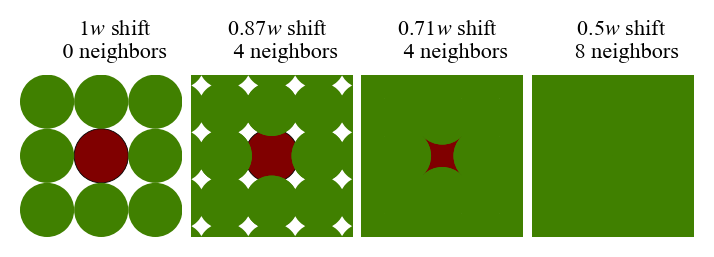

In [10]:
plot_with_neighbors(
    'figures/2D_grid_circle.pdf',
    draw_circles,
    rectangular_neighbors,
#     shifts = [1, 4/5, 3/5, 2/5],
)

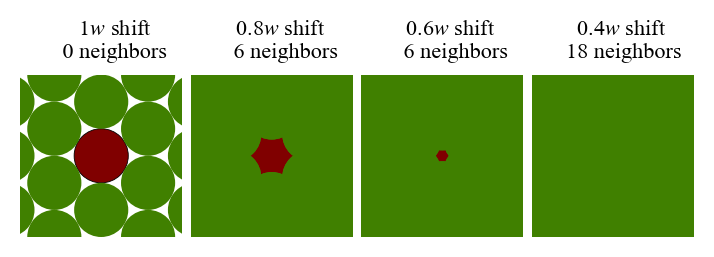

In [11]:
plot_with_neighbors(
    'figures/2D_hex_circle.pdf',
    draw_circles,
    hexagonal_neighbors,
    shifts = [1, 4/5, 3/5, 2/5],
)

MURA is length 5


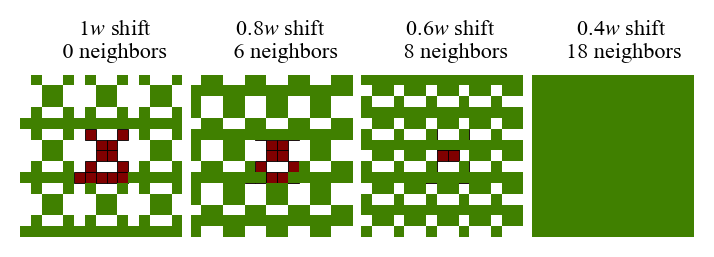

In [12]:
mura = xdesign.mura_2d(5)

plot_with_neighbors(
    'figures/2D_grid_mura5.pdf',
    draw_mura,
    rectangular_neighbors,
    dkwargs={'mura': mura},
    nkwargs={'circles': False},
    shifts = [1, 4/5, 3/5, 2/5],
)

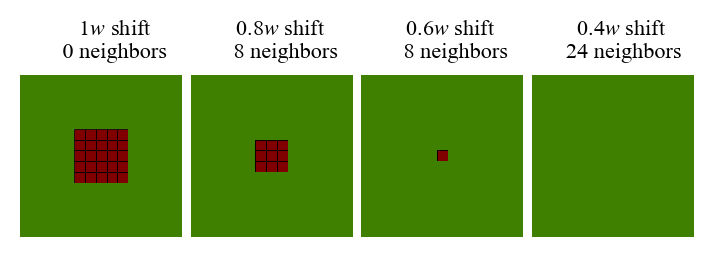

In [13]:
plot_with_neighbors(
    'figures/2D_grid_mura1.pdf',
    draw_mura,
    rectangular_neighbors,
    dkwargs={'mura': np.ones([5, 5], dtype=bool)},
    nkwargs={'circles': False},
    shifts = [1, 4/5, 3/5, 2/5],
)

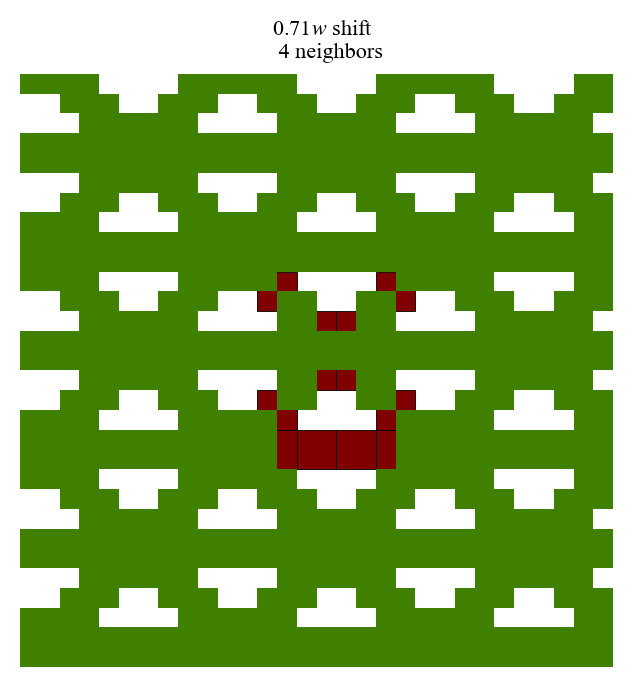

In [14]:
plot_with_neighbors(
    'figures/2D_fcc_mura5.pdf',
    draw_mura,
    fcc_neighbors,
    dkwargs={'mura': mura},
    nkwargs={'circles': False},
    shifts = [np.sqrt(2)/2],
)

In [42]:
#########|#########|#########|#########|#########|#########|#########|#########|

import matplotlib.pyplot as plt
import numpy as np

def plot_holes(
    name,
    draw_function,
    neighbor_function,
    nkwargs={},
    sizes=[13, 17, 29, 37, 41, 53, 61, 73, 89, 97, 101, 109, 113]
):
    import itertools
    markers = itertools.cycle([(i,j,0) for i in range(2,10) for j in range(1, 3)])
    
    plt.figure(figsize=(3.37, 3.37 / 5 + 3.37 / 10), dpi=200)
    for size in sizes:
        mura = xdesign.mura_2d(size)
        dkwargs={'mura': mura}
        shifts = (np.arange(mura.shape[0]) + 1) / mura.shape[0]
        num_holes = list()
        for i, shift in enumerate(shifts):
            # Compute all the neighbors
            h, v, = neighbor_function(shift, **nkwargs)
            num_holes.append(count_holes(h * mura.shape[0], v * mura.shape[1], grid=dkwargs['mura']))

        density = 1 - np.asarray(num_holes) / np.prod(mura.shape)
        print(density)
        plt.scatter(shifts, density, s=3, marker=next(markers))
    plt.xlabel('shift')
    plt.ylabel('covered area')
    ticks = np.linspace(0, 1, 6, endpoint=True)
    plt.xticks(ticks, ["{:2.1f}w".format(x) for x in ticks])
    plt.legend(sizes, ncol=2, columnspacing=0, labelspacing=0.1, handletextpad=0)
    plt.subplots_adjust(left=0.12, right=.98, bottom=0.2, top=0.98)
    plt.savefig(name, dpi=600)
    plt.show()

MURA is length 17
[1.         1.         1.         1.         1.         1.
 0.7716263  0.90311419 0.88927336 0.97231834 0.75086505 0.75086505
 0.75086505 0.55709343 0.55709343 0.55709343 0.5017301 ]
MURA is length 41
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.98215348
 1.         0.97501487 0.93218322 0.84176086 0.95478882 0.9666865
 0.88697204 0.92861392 0.82867341 0.8810232  0.76680547 0.82867341
 0.92385485 0.8810232  0.76680547 0.76680547 0.76680547 0.76680547
 0.61451517 0.61451517 0.76680547 0.69541939 0.5240928  0.61451517
 0.61451517 0.5240928  0.5240928  0.5240928  0.50029744]
MURA is length 61
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.9677506  1.
 1.         1.         0.99140016 1.         1.         0.98065036
 0.98280032 0.98065036 0.94840097 0.86240258 0.9677506  0.93550121
 0.99140016 0.90970169 0.87960226 0.96560064 0.90970169 0.862

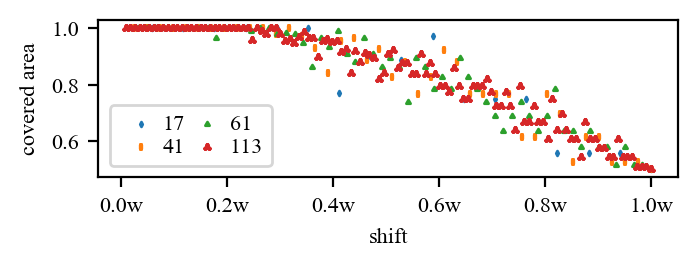

In [43]:
plot_holes(
    'figures/2D_grid_mura_holes.pdf',
    draw_mura,
    rectangular_neighbors,
    nkwargs={'circles': False},
    sizes=[17, 41, 61, 113]
)

In [17]:
import matplotlib.pyplot as plt

[plt.plot(i, 0, marker = next(markers), ms=10) for i in range(16)]

NameError: name 'markers' is not defined

In [ ]:
next(markers)